In [1]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# For iSOM Data Generation
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

# For TabPFN Model
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score, accuracy_score

# --- Installation Note ---
# !pip install tabpfn minisom sklearn pandas seaborn matplotlib

print("Setup Complete!")

Setup Complete!


In [2]:
# ===================================================================
# Cell 2: Interpretable SOM (iSOM) Synthetic Data Generator (Corrected)
# ===================================================================

def generate_isom_data(df_real, target_column, num_synthetic):
    """
    Generates synthetic data by training a SOM on real data and
    interpolating between neighboring nodes.
    """
    if num_synthetic <= 0:
        return pd.DataFrame(columns=df_real.columns)

    print(f"Generating {num_synthetic} synthetic samples from a base of {len(df_real)} real samples...")
    
    X_real = df_real.drop(columns=[target_column]).values
    y_real = df_real[target_column].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_real)

    map_size = int(np.sqrt(5 * np.sqrt(X_scaled.shape[0])))
    som_grid_size = (map_size, map_size)
    
    som = MiniSom(som_grid_size[0], som_grid_size[1], X_scaled.shape[1],
                  sigma=1.0, learning_rate=0.5, random_seed=42)
    som.random_weights_init(X_scaled)
    som.train_random(X_scaled, 500)

    def get_neighbors(x, y, grid_size):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1]:
                neighbors.append((nx, ny))
        return neighbors

    weights = som.get_weights()
    synthetic_samples = []
    rng = np.random.default_rng(42)

    for _ in range(num_synthetic):
        x1, y1 = rng.integers(som_grid_size[0]), rng.integers(som_grid_size[1])
        valid_neighbors = get_neighbors(x1, y1, som_grid_size)
        if not valid_neighbors: continue
        x2, y2 = rng.choice(valid_neighbors)
        node1_weights, node2_weights = weights[x1, y1], weights[x2, y2]
        alpha = rng.random()
        new_sample_scaled = alpha * node1_weights + (1 - alpha) * node2_weights
        distances = np.linalg.norm(X_scaled - new_sample_scaled, axis=1)
        new_target = y_real[np.argmin(distances)]
        synthetic_samples.append(np.append(new_sample_scaled, new_target))

    synthetic_df = pd.DataFrame(synthetic_samples, columns=df_real.columns)
    synthetic_features_scaled = synthetic_df.drop(columns=[target_column]).values
    synthetic_features_orig = scaler.inverse_transform(synthetic_features_scaled)
    synthetic_df[df_real.drop(columns=[target_column]).columns] = synthetic_features_orig
    
    synthetic_df[target_column] = synthetic_df[target_column].astype(int)
    
    return synthetic_df

In [3]:
# ===================================================================
# Cell 3: Helper Functions (from your utils.py)
# ===================================================================
# Same as before, for self-containment.

def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet": return pd.read_parquet(path)
    elif ext == ".csv": return pd.read_csv(path, index_col=0)

def load_data(base_path):
    _, dataset_name = os.path.split(base_path)
    with open(os.path.join(base_path, f"{dataset_name}.meta.json")) as f: meta = json.load(f)
    train_data = read_data(os.path.join(base_path, f"{dataset_name}.{meta['format']}"))
    test_path = os.path.join(base_path, f"{dataset_name}_test.{meta['format']}")
    test_data = read_data(test_path) if os.path.exists(test_path) else train_data
    return train_data, test_data, meta

def get_indices_for_repeat(base_path, repeat_idx):
    """Gets the full, shuffled list of indices for a single repeat run."""
    train_idx_file = os.path.join(base_path, "train_indices.parquet")
    train_idx_splits = pd.read_parquet(train_idx_file)
    col_name = train_idx_splits.columns[repeat_idx]
    return train_idx_splits[col_name].values

In [4]:
# ===================================================================
# Cell 4: Experiment Configuration
# ===================================================================
BASE_DATA_PATH = "data"
DATASET_NAME = "welded_beam" 
REPEATS = 3 # Keep this low for faster testing, increase for final results

# === NEW PARAMETERS FOR THIS EXPERIMENT ===
# 1. Fractions of REAL data to use as a fixed base
FIXED_REAL_FRACTIONS = [0.1, 0.2]

# 2. Fractions of SYNTHETIC data to add (0.0 means training on the fixed real set only)
SYNTHETIC_ADD_FRACTIONS = np.arange(0.0, 0.6, 0.1).round(1)

# 3. Fractions for the baseline comparison (real data only)
BASELINE_REAL_FRACTIONS = np.arange(0.1, 0.8, 0.1).round(1)

# --- Derived parameters ---
DATASET_PATH = os.path.join(BASE_DATA_PATH, DATASET_NAME)

In [5]:
# ===================================================================
# Cell 5: Load Data and Prepare
# ===================================================================

train_data, test_data, meta = load_data(DATASET_PATH)
X_columns, y_column = train_data.columns.drop(meta["label"]), meta["label"]
X_test, y_test = test_data[X_columns], test_data[y_column]
full_train_size = len(train_data)
all_results = []

classifier = TabPFNClassifier(device="cuda")

In [6]:
# ===================================================================
# Cell 6: Run Experiments (Corrected)
# ===================================================================

for i in tqdm(range(REPEATS), desc="Total Repeats"):
    # Get the shuffled indices for this entire repeat run
    shuffled_indices = get_indices_for_repeat(DATASET_PATH, i)
    
    # --- Experiment A: Baseline using only Real Data ---
    for real_fraction in tqdm(BASELINE_REAL_FRACTIONS, desc=f"Repeat {i+1} - Baseline"):
        n_real = int(real_fraction * full_train_size)
        train_indices = shuffled_indices[:n_real]
        
        X_train = train_data.loc[train_indices, X_columns]
        y_train = train_data.loc[train_indices, y_column]
        
        # --- RELIABLE FIX ---
        # Force the target to be an integer before fitting
        y_train = y_train.astype(int)
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        # Also ensure y_test is integer for scoring
        score = f1_score(y_test.astype(int), y_pred, average="macro")
        all_results.append({"experiment": "Baseline (Real Only)", 
                            "total_fraction": real_fraction, 
                            "f1_score": score})

    # --- Experiment B: Incremental Augmentation ---
    for real_fraction in tqdm(FIXED_REAL_FRACTIONS, desc=f"Repeat {i+1} - Augmented"):
        n_real = int(real_fraction * full_train_size)
        real_indices = shuffled_indices[:n_real]
        train_subset_real = train_data.loc[real_indices]
        
        for synthetic_fraction in SYNTHETIC_ADD_FRACTIONS:
            n_synthetic = int(synthetic_fraction * full_train_size)
            
            # Generate synthetic data
            train_subset_synthetic = generate_isom_data(train_subset_real, y_column, n_synthetic)
            
            # Combine for training
            train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)
            X_train = train_augmented[X_columns]
            y_train = train_augmented[y_column]
            
            # --- RELIABLE FIX ---
            # Force the combined target to be an integer before fitting
            y_train = y_train.astype(int)
            
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            
            # Also ensure y_test is integer for scoring
            score = f1_score(y_test.astype(int), y_pred, average="macro")
            total_fraction = round(real_fraction + synthetic_fraction, 1)
            all_results.append({"experiment": f"Start {int(real_fraction*100)}% Real + iSOM", 
                                "total_fraction": total_fraction, 
                                "f1_score": score})

results_df = pd.DataFrame(all_results)
print("\nAll experiments complete!")

Total Repeats:   0%|          | 0/3 [00:00<?, ?it/s]

Repeat 1 - Baseline:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\johnn\Documents\From Desktop\All things Python\env\lib\site-packages\tabpfn\architectures\base\attention\full_attention.py:678: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attention_head_outputs = torch.nn.functional.scaled_dot_product_attention(


Repeat 1 - Augmented:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 200 real samples...
Generating 400 synthetic samples from a base of 200 real samples...
Generating 600 synthetic samples from a base of 200 real samples...
Generating 800 synthetic samples from a base of 200 real samples...
Generating 1000 synthetic samples from a base of 200 real samples...


C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 400 real samples...
Generating 400 synthetic samples from a base of 400 real samples...
Generating 600 synthetic samples from a base of 400 real samples...
Generating 800 synthetic samples from a base of 400 real samples...
Generating 1000 synthetic samples from a base of 400 real samples...


Repeat 2 - Baseline:   0%|          | 0/7 [00:00<?, ?it/s]

Repeat 2 - Augmented:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 200 real samples...
Generating 400 synthetic samples from a base of 200 real samples...
Generating 600 synthetic samples from a base of 200 real samples...
Generating 800 synthetic samples from a base of 200 real samples...
Generating 1000 synthetic samples from a base of 200 real samples...


C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 400 real samples...
Generating 400 synthetic samples from a base of 400 real samples...
Generating 600 synthetic samples from a base of 400 real samples...
Generating 800 synthetic samples from a base of 400 real samples...
Generating 1000 synthetic samples from a base of 400 real samples...


Repeat 3 - Baseline:   0%|          | 0/7 [00:00<?, ?it/s]

Repeat 3 - Augmented:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 200 real samples...
Generating 400 synthetic samples from a base of 200 real samples...
Generating 600 synthetic samples from a base of 200 real samples...
Generating 800 synthetic samples from a base of 200 real samples...
Generating 1000 synthetic samples from a base of 200 real samples...


C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 400 real samples...
Generating 400 synthetic samples from a base of 400 real samples...
Generating 600 synthetic samples from a base of 400 real samples...
Generating 800 synthetic samples from a base of 400 real samples...
Generating 1000 synthetic samples from a base of 400 real samples...

All experiments complete!


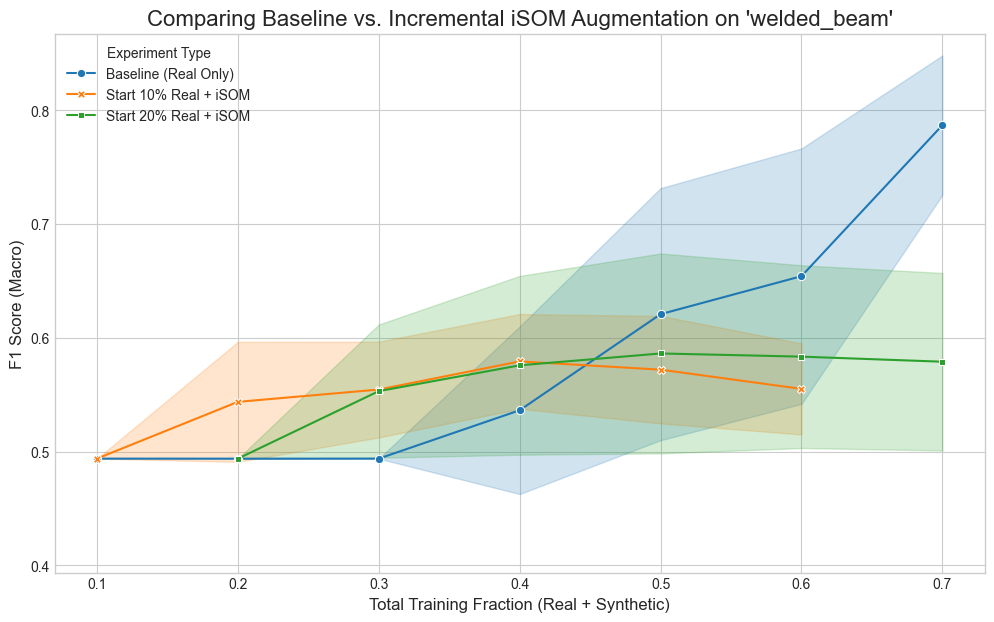

In [7]:
# ===================================================================
# Cell 7: Visualize Results
# ===================================================================

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(
    data=results_df,
    x="total_fraction",
    y="f1_score",
    hue="experiment",
    style="experiment",
    markers=True,
    dashes=False,
    ax=ax,
    errorbar="sd"
)

ax.set_title(f"Comparing Baseline vs. Incremental iSOM Augmentation on '{DATASET_NAME}'", fontsize=16)
ax.set_xlabel("Total Training Fraction (Real + Synthetic)", fontsize=12)
ax.set_ylabel("F1 Score (Macro)", fontsize=12)
ax.legend(title="Experiment Type")
ax.set_ylim(bottom=max(0, results_df.f1_score.min() - 0.1))

plt.show()

In [8]:
FIXED_REAL_FRACTIONS = [0.3, 0.4]

# ===================================================================
# Cell 5: Load Data and Prepare
# ===================================================================

train_data, test_data, meta = load_data(DATASET_PATH)
X_columns, y_column = train_data.columns.drop(meta["label"]), meta["label"]
X_test, y_test = test_data[X_columns], test_data[y_column]
full_train_size = len(train_data)
all_results = []

classifier = TabPFNClassifier(device="cuda")

In [9]:
# ===================================================================
# Cell 6: Run Experiments (Corrected)
# ===================================================================

for i in tqdm(range(REPEATS), desc="Total Repeats"):
    # Get the shuffled indices for this entire repeat run
    shuffled_indices = get_indices_for_repeat(DATASET_PATH, i)
    
    # --- Experiment A: Baseline using only Real Data ---
    for real_fraction in tqdm(BASELINE_REAL_FRACTIONS, desc=f"Repeat {i+1} - Baseline"):
        n_real = int(real_fraction * full_train_size)
        train_indices = shuffled_indices[:n_real]
        
        X_train = train_data.loc[train_indices, X_columns]
        y_train = train_data.loc[train_indices, y_column]
        
        # --- RELIABLE FIX ---
        # Force the target to be an integer before fitting
        y_train = y_train.astype(int)
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        # Also ensure y_test is integer for scoring
        score = f1_score(y_test.astype(int), y_pred, average="macro")
        all_results.append({"experiment": "Baseline (Real Only)", 
                            "total_fraction": real_fraction, 
                            "f1_score": score})

    # --- Experiment B: Incremental Augmentation ---
    for real_fraction in tqdm(FIXED_REAL_FRACTIONS, desc=f"Repeat {i+1} - Augmented"):
        n_real = int(real_fraction * full_train_size)
        real_indices = shuffled_indices[:n_real]
        train_subset_real = train_data.loc[real_indices]
        
        for synthetic_fraction in SYNTHETIC_ADD_FRACTIONS:
            n_synthetic = int(synthetic_fraction * full_train_size)
            
            # Generate synthetic data
            train_subset_synthetic = generate_isom_data(train_subset_real, y_column, n_synthetic)
            
            # Combine for training
            train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)
            X_train = train_augmented[X_columns]
            y_train = train_augmented[y_column]
            
            # --- RELIABLE FIX ---
            # Force the combined target to be an integer before fitting
            y_train = y_train.astype(int)
            
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            
            # Also ensure y_test is integer for scoring
            score = f1_score(y_test.astype(int), y_pred, average="macro")
            total_fraction = round(real_fraction + synthetic_fraction, 1)
            all_results.append({"experiment": f"Start {int(real_fraction*100)}% Real + iSOM", 
                                "total_fraction": total_fraction, 
                                "f1_score": score})

results_df = pd.DataFrame(all_results)
print("\nAll experiments complete!")

Total Repeats:   0%|          | 0/3 [00:00<?, ?it/s]

Repeat 1 - Baseline:   0%|          | 0/7 [00:00<?, ?it/s]

Repeat 1 - Augmented:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 600 real samples...
Generating 400 synthetic samples from a base of 600 real samples...
Generating 600 synthetic samples from a base of 600 real samples...
Generating 800 synthetic samples from a base of 600 real samples...
Generating 1000 synthetic samples from a base of 600 real samples...


C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 800 real samples...
Generating 400 synthetic samples from a base of 800 real samples...
Generating 600 synthetic samples from a base of 800 real samples...
Generating 800 synthetic samples from a base of 800 real samples...
Generating 1000 synthetic samples from a base of 800 real samples...


Repeat 2 - Baseline:   0%|          | 0/7 [00:00<?, ?it/s]

Repeat 2 - Augmented:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 600 real samples...
Generating 400 synthetic samples from a base of 600 real samples...
Generating 600 synthetic samples from a base of 600 real samples...
Generating 800 synthetic samples from a base of 600 real samples...
Generating 1000 synthetic samples from a base of 600 real samples...


C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 800 real samples...
Generating 400 synthetic samples from a base of 800 real samples...
Generating 600 synthetic samples from a base of 800 real samples...
Generating 800 synthetic samples from a base of 800 real samples...
Generating 1000 synthetic samples from a base of 800 real samples...


Repeat 3 - Baseline:   0%|          | 0/7 [00:00<?, ?it/s]

Repeat 3 - Augmented:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 600 real samples...
Generating 400 synthetic samples from a base of 600 real samples...
Generating 600 synthetic samples from a base of 600 real samples...
Generating 800 synthetic samples from a base of 600 real samples...
Generating 1000 synthetic samples from a base of 600 real samples...


C:\Users\johnn\AppData\Local\Temp\ipykernel_22604\4108536962.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_augmented = pd.concat([train_subset_real, train_subset_synthetic], ignore_index=True)


Generating 200 synthetic samples from a base of 800 real samples...
Generating 400 synthetic samples from a base of 800 real samples...
Generating 600 synthetic samples from a base of 800 real samples...
Generating 800 synthetic samples from a base of 800 real samples...
Generating 1000 synthetic samples from a base of 800 real samples...

All experiments complete!


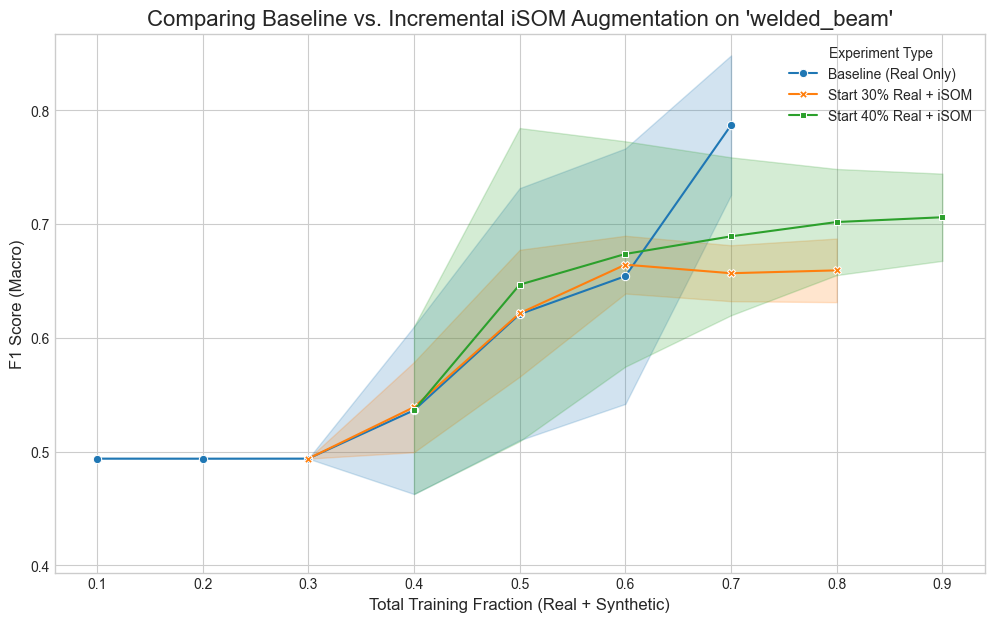

In [10]:
# ===================================================================
# Cell 7: Visualize Results
# ===================================================================

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(
    data=results_df,
    x="total_fraction",
    y="f1_score",
    hue="experiment",
    style="experiment",
    markers=True,
    dashes=False,
    ax=ax,
    errorbar="sd"
)

ax.set_title(f"Comparing Baseline vs. Incremental iSOM Augmentation on '{DATASET_NAME}'", fontsize=16)
ax.set_xlabel("Total Training Fraction (Real + Synthetic)", fontsize=12)
ax.set_ylabel("F1 Score (Macro)", fontsize=12)
ax.legend(title="Experiment Type")
ax.set_ylim(bottom=max(0, results_df.f1_score.min() - 0.1))

plt.show()